In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv(r"F:\College\SEM 8\Project Phase 2\Dataset\NCA Preprocessed\master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [4]:
# -------------------------
# 0. ONE-HOT encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 1. Drop unused columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 2. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns
                if 'temp_' in col or 'charge_rate_' in col]

# Convert to arrays
X_ic_all = df_dropped[ic_cols].values               # (N,20)
X_cycle_all = df_dropped[[cycle_col]].values        # (N,1)
X_onehot_all = df_dropped[one_hot_cols].values      # (N,6)
Y = df_dropped['SOH'].values                        # (N,)

# ---------------------------------------------------
# 3. Remove NaN / INF first
# ---------------------------------------------------
mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Rows removed due to NaN/Inf:", np.sum(~mask_clean))

X_ic_all     = X_ic_all[mask_clean]
X_cycle_all  = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y            = Y[mask_clean]


# ---------------------------------------------------
# 4. REMOVE IC OUTLIERS (YOUR RULE: IC < 0 OR IC > 20)
# ---------------------------------------------------
LOW_LIMIT  = 0
HIGH_LIMIT = 20

mask_outlier = np.all(
    (X_ic_all >= LOW_LIMIT) & (X_ic_all <= HIGH_LIMIT),
    axis=1
)

print("Rows removed due to IC outliers:", np.sum(~mask_outlier))

# Apply mask everywhere
X_ic_all     = X_ic_all[mask_outlier]
X_cycle_all  = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y            = Y[mask_outlier]


# -------------------------
# 5. Train-test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_onehot_train, X_onehot_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 6. Standardize IC bins
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 7. Standardize cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 8. Build context vector = cycle + one-hot
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_onehot_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_onehot_test], axis=1)

# -------------------------
# 9. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test  = (y_test - y_mean) / y_std

# -------------------------
# 10. Expand dims for CNN/LSTM input
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

# -------------------------
# 11. Print final shapes & ranges
# -------------------------
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("IC:", X_ic_train.shape)
print("Context:", X_context_train.shape)
print("Y:", y_train.shape)


Rows removed due to NaN/Inf: 3
Rows removed due to IC outliers: 4
Final IC range: -8.413057359147434 11.611967272321516
IC: (18109, 20, 1)
Context: (18109, 7)
Y: (18109,)


In [5]:
from tensorflow import keras
import tensorflow as tf

Loading all adversarially trained models

In [6]:
jsma_cnn_lstm = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\jsma_trained_cnn_lstm.keras")
candw_cnn_gru = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\c&w_trained_cnn_gru.keras")
fgsm_cnn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\fgsm_trained_cnn.keras")
pgd_rcn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\pgd_trained_rcn.keras")

Loading all clean models

In [7]:
cnn_lstm = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn_lstm.keras")
cnn_gru = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn_gru.keras")
cnn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn.keras")
rcn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_rcn.keras")

attack functions

In [9]:
@tf.function
def candw_attack(model, x_ic_batch, x_ctx_batch, y_batch,
                 attack_weight=1.0, lr=0.01, steps=100,
                 clip_min=-3.0, clip_max=3.0):

    x_ic_batch = tf.cast(x_ic_batch, tf.float32)
    x_ctx_batch = tf.cast(x_ctx_batch, tf.float32)
    y_batch = tf.cast(y_batch, tf.float32)
    y_batch = tf.expand_dims(y_batch, axis=-1)

    # make all constants float32
    clip_min = tf.cast(clip_min, tf.float32)
    clip_max = tf.cast(clip_max, tf.float32)
    attack_weight = tf.cast(attack_weight, tf.float32)
    lr = tf.cast(lr, tf.float32)

    # steps must be int32 for tf.while_loop
    steps = tf.cast(steps, tf.int32)

    delta = tf.zeros_like(x_ic_batch, dtype=tf.float32)

    def body(i, delta):
        with tf.GradientTape() as tape:
            tape.watch(delta)

            x_adv = x_ic_batch + delta
            x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

            y_pred = model([x_adv, x_ctx_batch], training=False)

            mse = tf.reduce_mean(tf.keras.losses.MSE(y_batch, y_pred))
            l2 = tf.reduce_mean(tf.reduce_sum(tf.square(delta), axis=[1, 2]))

            loss = l2 - attack_weight * mse

        grads = tape.gradient(loss, delta)
        delta = delta - lr * grads
        return i + 1, delta

    _, delta = tf.while_loop(
        cond=lambda i, _: i < steps,
        body=body,
        loop_vars=(0, delta)
    )

    x_adv = tf.clip_by_value(x_ic_batch + delta, clip_min, clip_max)
    return x_adv


In [10]:
@tf.function
def fgsm_attack(model, X_ic, X_ctx, y_true, epsilon=0.05):

    X_ic = tf.cast(X_ic, tf.float32)
    X_ctx = tf.cast(X_ctx, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(X_ic)
        y_pred = model([X_ic, X_ctx], training=False)
        loss = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))

    grad = tape.gradient(loss, X_ic)
    signed_grad = tf.sign(grad)

    X_ic_adv = X_ic + epsilon * signed_grad

    return X_ic_adv


In [11]:
def jsma_attack(
    model,
    X_ic,
    X_ctx,
    y_true,
    epsilon=0.7,
    k=3,
    clip_min=-3.0,
    clip_max=3.0
):
    """
    JSMA attack (EAGER ONLY — cannot be @tf.function)
    """

    X_ic_np = np.asarray(X_ic, dtype=np.float32)
    X_ctx_np = np.asarray(X_ctx, dtype=np.float32)
    y_np = np.asarray(y_true, dtype=np.float32)

    X_ic_adv = X_ic_np.copy()

    for i in range(X_ic_np.shape[0]):

        x_var = tf.Variable(X_ic_np[i:i+1])
        ctx_i = tf.convert_to_tensor(X_ctx_np[i:i+1])
        y_i = tf.convert_to_tensor(y_np[i:i+1])

        with tf.GradientTape() as tape:
            tape.watch(x_var)
            pred = model([x_var, ctx_i], training=False)
            loss = tf.reduce_mean(tf.keras.losses.MSE(y_i, pred))

        grad = tape.gradient(loss, x_var)
        if grad is None:
            continue

        grad_flat = grad.numpy().reshape(-1)
        saliency = np.abs(grad_flat)

        topk_idx = np.argsort(saliency)[-k:]

        for idx in topk_idx:
            X_ic_adv[i, idx, 0] += epsilon * np.sign(grad_flat[idx])

    X_ic_adv = np.clip(X_ic_adv, clip_min, clip_max)

    return tf.convert_to_tensor(X_ic_adv, dtype=tf.float32)


In [12]:
@tf.function
def pgd_attack(
    model,
    X_ic,
    X_ctx,
    y_true,
    alpha=0.01,
    epsilon=0.05,
    num_iterations=10
):
    """
    PGD attack (graph-compiled)
    """

    X_ic = tf.cast(X_ic, tf.float32)
    X_ctx = tf.cast(X_ctx, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Save original input for projection
    X_ic_orig = X_ic

    # Initialize adversarial example
    X_ic_adv = tf.identity(X_ic)

    for _ in tf.range(num_iterations):   # tf.range for graph safety
        with tf.GradientTape() as tape:
            tape.watch(X_ic_adv)
            y_pred = model([X_ic_adv, X_ctx], training=False)
            loss = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))

        grad = tape.gradient(loss, X_ic_adv)
        signed_grad = tf.sign(grad)

        # Gradient ascent step
        X_ic_adv = X_ic_adv + alpha * signed_grad

        # Projection to epsilon-ball
        X_ic_adv = tf.clip_by_value(
            X_ic_adv,
            X_ic_orig - epsilon,
            X_ic_orig + epsilon
        )

    return X_ic_adv


In [31]:
import random
from tqdm import tqdm 

In [29]:
attacks = ['FGSM', 'PGD', 'CandW', 'JSMA', 'Clean']
print(random.choice(attacks))

JSMA


In [35]:
batch_size = 32

y_train_tf = y_train.reshape(-1,1).astype(np.float32)
y_test_tf = y_test.reshape(-1,1).astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_train.astype(np.float32),X_context_train.astype(np.float32),
     y_train_tf)).shuffle(buffer_size=len(X_ic_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_test.astype(np.float32), X_context_test.astype(np.float32),
    y_test_tf)).batch(batch_size)


In [41]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

meta_input = Input(shape=(5,), name="meta_input")

x = Dense(16, activation="relu")(meta_input)
x = Dense(8, activation="relu")(x)

meta_output = Dense(1, activation="linear")(x)

meta_model = Model(meta_input, meta_output)

meta_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

meta_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ meta_input (InputLayer)         │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from collections import defaultdict




In [ ]:
epsilon = 0.01
learning_rate = 1e-5

best_val_mse = float('inf')
patience = 10
patience_counter = 0
epochs = 20

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_loss_fn = MeanSquaredError()

train_mae_history = []
train_mse_history = []
val_mse_history = []

attacks = ['FGSM', 'PGD', 'CandW', 'JSMA', 'Clean']
weights = [0.25,   0.25,  0.20,   0.05,   0.25]


for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    total_mse = 0.0
    total_mae = 0.0
    num_batches = 0 

    train_pbar = tqdm(train_dataset, desc = "Training", leave=True)
    for(x_ic_batch, x_ctx_batch, y_batch) in train_pbar:
        attack_choice = random.choices(attacks, weights=weights, k=1)[0]


        if(attack_choice=="FGSM"):
            x_ic_adv = fgsm_attack(cnn, x_ic_batch, x_ctx_batch, y_batch)
        elif(attack_choice=="PGD"):
            x_ic_adv = pgd_attack(rcn, x_ic_batch, x_ctx_batch, y_batch)
        elif(attack_choice=="CandW"):
            x_ic_adv = candw_attack(cnn_gru, x_ic_batch, x_ctx_batch, y_batch)
        elif(attack_choice=="JSMA"):
            x_ic_adv = jsma_attack(cnn_lstm, x_ic_batch, x_ctx_batch, y_batch)
        else:
            x_ic_adv = x_ic_batch

        cnn_pred = fgsm_cnn.predict([x_ic_adv, x_ctx_batch], verbose=0)
        rcn_pred = pgd_rcn.predict([x_ic_adv, x_ctx_batch], verbose=0)
        cnn_lstm_pred = jsma_cnn_lstm.predict([x_ic_adv, x_ctx_batch], verbose=0)
        cnn_gru_pred = candw_cnn_gru.predict([x_ic_adv, x_ctx_batch], verbose=0)
        clean_gru_pred = cnn_gru.predict([x_ic_adv, x_ctx_batch], verbose=0)

        meta_input = np.column_stack([cnn_pred, rcn_pred, cnn_lstm_pred, cnn_gru_pred, clean_gru_pred])

        with tf.GradientTape() as tape:
            y_pred_meta = meta_model(meta_input, training=True)
            mse_loss = mse_loss_fn(y_batch, y_pred_meta)
        
        grads = tape.gradient(mse_loss, meta_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, meta_model.trainable_variables))

        mae_metric.reset_state()
        mae_metric.update_state(y_batch, y_pred_meta)
        batch_mae = mae_metric.result().numpy()

        total_mse += mse_loss.numpy()
        total_mae += batch_mae
        num_batches+=1

        train_pbar.set_postfix(mse = f"{mse_loss.numpy():.6f}", mae=f"{batch_mae:.6f}")

    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches

    print(f"Train MSE: {avg_mse:.4f} | Train MAE: {avg_mae:.4f}")

    # -------------------------
    # Validation (CLEAN only)
    # -------------------------
    val_mse = 0.0
    val_batches = 0

    for x_ic_batch, x_ctx_batch, y_batch in test_dataset:
        p1 = fgsm_cnn.predict([x_ic_batch, x_ctx_batch], verbose=0)
        p2 = pgd_rcn.predict([x_ic_batch, x_ctx_batch], verbose=0)
        p3 = jsma_cnn_lstm.predict([x_ic_batch, x_ctx_batch], verbose=0)
        p4 = candw_cnn_gru.predict([x_ic_batch, x_ctx_batch], verbose=0)
        p5 = cnn_gru.predict([x_ic_batch, x_ctx_batch], verbose=0)

        meta_input = np.concatenate([p1, p2, p3, p4, p5], axis=1)
        pred = meta_model(meta_input, training=False)

        val_mse += mse_loss_fn(y_batch, pred).numpy()
        val_batches += 1

    val_mse /= val_batches
    print(f"Validation MSE: {val_mse:.4f}")

    # Early stopping
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        patience_counter = 0
        meta_model.save("best_meta_learner.keras")
        print("Validation improved — model saved")
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/20


Training:   1%|          | 5/566 [00:06<11:28,  1.23s/it, mae=0.658410, mse=0.589534]


KeyboardInterrupt: 

In [13]:
X_ic_adv_fgsm_cnn = fgsm_attack(cnn, X_ic_test, X_context_test, y_test, epsilon=0.05)
X_ic_adv_jsma_lstm = jsma_attack(cnn_lstm, X_ic_test, X_context_test, y_test, epsilon=0.7, k=3)
X_ic_adv_cw_gru = candw_attack(cnn_gru, X_ic_test, X_context_test, y_test)
X_ic_adv_pgd_rcn = pgd_attack(rcn, X_ic_test, X_context_test, y_test)

In [15]:
from sklearn.metrics import r2_score

In [16]:
def ensemble_eval(y_test,fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title=""):

    mse_fgsm = mean_squared_error(y_test, fgsm_cnn_pred)
    mse_jsma = mean_squared_error(y_test, jsma_lstm_pred)
    mse_cw   = mean_squared_error(y_test, cw_gru_pred)
    mse_pgd  = mean_squared_error(y_test, pgd_rcn_pred)
    mse_base = mean_squared_error(y_test, base_gru_pred)

    print("FGSM CNN MSE:", mse_fgsm)
    print("JSMA LSTM MSE:", mse_jsma)
    print("CW GRU MSE:", mse_cw)
    print("PGD RCN MSE:", mse_pgd)
    print("BASE MSE:", mse_base)

    predictions = np.column_stack((fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred))

    meta_model = keras.models.load_model(r"C:\Users\saman\Downloads\best_meta_learner_mlp.keras")
    final_pred = meta_model.predict(predictions)

    mse_ens = mean_squared_error(y_test, final_pred)
    mae_ens = mean_absolute_error(y_test, final_pred)
    r2_ens  = r2_score(y_test, final_pred)

    print("\n===== Ensemble Performance " + title + " attacked Data=====")
    print("MSE:", mse_ens)
    print("MAE:", mae_ens)
    print("R² :", r2_ens)

    plt.scatter(y_test, final_pred, alpha = 0.5)
    plt.plot([-2,2],[-2,2],"r--")
    plt.title(title+" attacked data max voting predictions")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()
    plt.show()   


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FGSM CNN MSE: 0.025786202608043648
JSMA LSTM MSE: 0.00502414624254074
CW GRU MSE: 0.005220734245936118
PGD RCN MSE: 0.007305212615244743
BASE MSE: 0.6790300645175265


c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

===== Ensemble Performance FGSM attacked Data=====
MSE: 0.10648199322130224
MAE: 0.21472877212092292
R² : 0.8938093445761774


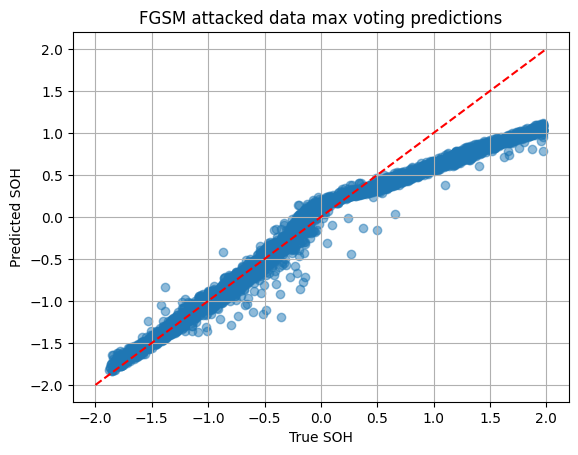

In [17]:
fgsm_cnn_pred = fgsm_cnn.predict([X_ic_adv_fgsm_cnn, X_context_test])
jsma_lstm_pred = jsma_cnn_lstm.predict([X_ic_adv_fgsm_cnn, X_context_test])
cw_gru_pred = candw_cnn_gru.predict([X_ic_adv_fgsm_cnn, X_context_test])
pgd_rcn_pred = pgd_rcn.predict([X_ic_adv_fgsm_cnn,X_context_test])

base_gru_pred = cnn_gru.predict([X_ic_adv_fgsm_cnn, X_context_test])

ensemble_eval(y_test, fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title="FGSM")


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FGSM CNN MSE: 0.0946962045922485
JSMA LSTM MSE: 0.10896259005103658
CW GRU MSE: 0.09902321945164597
PGD RCN MSE: 0.02555832210985957
BASE MSE: 0.7953098428375135
 95/142 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step

c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

===== Ensemble Performance JSMA attacked Data=====
MSE: 0.1474860605905812
MAE: 0.3085677095281021
R² : 0.8529174655151155


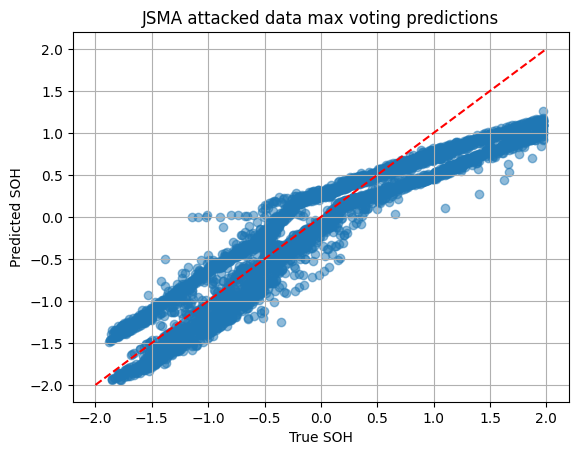

In [20]:
fgsm_cnn_pred = fgsm_cnn.predict([X_ic_adv_jsma_lstm, X_context_test])
jsma_lstm_pred =jsma_cnn_lstm.predict([X_ic_adv_jsma_lstm, X_context_test])
cw_gru_pred = candw_cnn_gru.predict([X_ic_adv_jsma_lstm, X_context_test])
pgd_rcn_pred = pgd_rcn.predict([X_ic_adv_jsma_lstm,X_context_test])

base_gru_pred = cnn_gru.predict([X_ic_adv_jsma_lstm, X_context_test])

ensemble_eval(y_test, fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title="JSMA")

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FGSM CNN MSE: 0.02804154227662347
JSMA LSTM MSE: 0.005181866609135436
CW GRU MSE: 0.005422043602204087
PGD RCN MSE: 0.00814254630745878
BASE MSE: 0.6991799809764587
 71/142 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step

c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

===== Ensemble Performance PGD attacked Data=====
MSE: 0.10974415353455837
MAE: 0.2197238515550344
R² : 0.8905561096274073


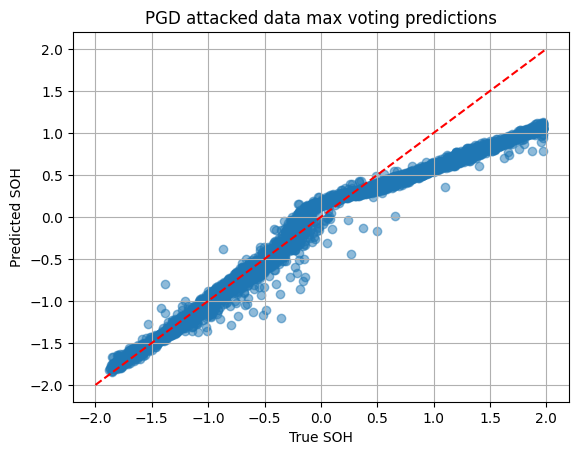

In [21]:
fgsm_cnn_pred = fgsm_cnn.predict([X_ic_adv_pgd_rcn, X_context_test])
jsma_lstm_pred = jsma_cnn_lstm.predict([X_ic_adv_pgd_rcn, X_context_test])
cw_gru_pred = candw_cnn_gru.predict([X_ic_adv_pgd_rcn, X_context_test])
pgd_rcn_pred = pgd_rcn.predict([X_ic_adv_pgd_rcn,X_context_test])

base_gru_pred = cnn_gru.predict([X_ic_adv_pgd_rcn, X_context_test])

ensemble_eval(y_test, fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title="PGD")

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FGSM CNN MSE: 0.027312409329513176
JSMA LSTM MSE: 0.006300838212770748
CW GRU MSE: 0.006358639161929951
PGD RCN MSE: 0.0065296051788387285
BASE MSE: 0.669396663182741
 84/142 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step

c:\Users\saman\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

===== Ensemble Performance C&W attacked Data=====
MSE: 0.10684966836414721
MAE: 0.21395991239136336
R² : 0.8934426754031032


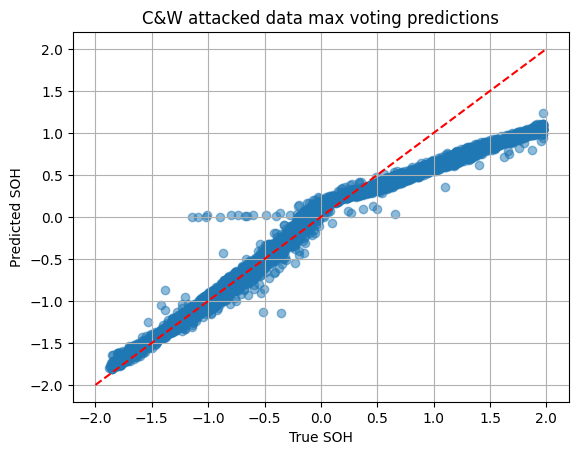

In [22]:
fgsm_cnn_pred = fgsm_cnn.predict([X_ic_adv_cw_gru, X_context_test])
jsma_lstm_pred = jsma_cnn_lstm.predict([X_ic_adv_cw_gru, X_context_test])
cw_gru_pred = candw_cnn_gru.predict([X_ic_adv_cw_gru, X_context_test])
pgd_rcn_pred = pgd_rcn.predict([X_ic_adv_cw_gru,X_context_test])

base_gru_pred = cnn_gru.predict([X_ic_adv_cw_gru, X_context_test])

ensemble_eval(y_test, fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title="C&W")